In [1]:
import nibabel as nib
import nilearn as nil
import numpy as np
import pandas as pd
import os
import os.path
from nilearn import plotting, image
from nipype.interfaces.spm import TwoSampleTTestDesign, EstimateModel, EstimateContrast, Threshold, MultipleRegressionDesign
from nipype.pipeline.engine import Workflow, Node, MapNode
import sys
sys.path.append('..')
from src.utils.data import getDataPandas, getPandas, getConfig, writePandas
os.chdir('..')

In [2]:
hc = getPandas('hc_data')
age_list = hc['AGE'].tolist()
img_list = hc['CAT12_SGM']
img_list = img_list.apply(os.path.abspath).tolist()

In [3]:
wf = Workflow(name='agecorrection', base_dir='tmp')

mr = Node(MultipleRegressionDesign(), name='mr')
mr.inputs.in_files = img_list
mr.inputs.include_intercept = True
mr.inputs.user_covariates = [
    {'name': 'age', 'vector': age_list}
]

model = Node(EstimateModel(), name='model')
model.inputs.estimation_method = {'Classical': 1}
#model.inputs.use_implicit_threshold = True

contrast = Node(EstimateContrast(), name='contrast')
con = ('age','T', ['age'],[1])
contrast.inputs.contrasts = [con]
contrast.inputs.group_contrast = True

threshold = Node(Threshold(
    contrast_index=1,
    use_topo_fdr=False,
    use_fwe_correction=True,
    extent_threshold=5,
    height_threshold=0.05,
    height_threshold_type='p-value',
    extent_fdr_p_threshold=0.05), name='thres')

wf.connect([
    (mr, model, [('spm_mat_file', 'spm_mat_file')]),
    (model, contrast, [('spm_mat_file', 'spm_mat_file'),
                        ('beta_images', 'beta_images'),
                        ('residual_image', 'residual_image')]),
    (contrast, threshold, [('spm_mat_file', 'spm_mat_file'),
                            ('spmT_images', 'stat_image')]),
])

wf.run()

230510-13:47:24,138 nipype.workflow INFO:
	 Workflow agecorrection settings: ['check', 'execution', 'logging', 'monitoring']
230510-13:47:24,146 nipype.workflow INFO:
	 Running serially.
230510-13:47:24,146 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.mr" in "/home/biobot/disk/ldopa/tmp/agecorrection/mr".
230510-13:47:24,151 nipype.workflow INFO:
	 [Node] Outdated cache found for "agecorrection.mr".
230510-13:47:24,159 nipype.workflow INFO:
	 [Node] Executing "mr" <nipype.interfaces.spm.model.MultipleRegressionDesign>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:47:34,684 nipype.workflow INFO:
	 [Node] Finished "mr", elapsed time 10.523667s.
230510-13:47:34,703 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.model" in "/home/biobot/disk/ldopa/tmp/agecorrection/model".
230510-13:47:34,705 nipype.workflow INFO:
	 [Node] Outdated cache found for "agecorrection.model".
230510-13:47:34,709 nipype.workflow INFO:
	 [Node] Executing "model" <nipype.interfaces.spm.model.EstimateModel>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:48:01,661 nipype.workflow INFO:
	 [Node] Finished "model", elapsed time 26.950987s.
230510-13:48:01,665 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.contrast" in "/home/biobot/disk/ldopa/tmp/agecorrection/contrast".
230510-13:48:01,666 nipype.workflow INFO:
	 [Node] Outdated cache found for "agecorrection.contrast".
230510-13:48:01,670 nipype.workflow INFO:
	 [Node] Executing "contrast" <nipype.interfaces.spm.model.EstimateContrast>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:48:12,413 nipype.workflow INFO:
	 [Node] Finished "contrast", elapsed time 10.741967s.
230510-13:48:12,416 nipype.workflow INFO:
	 [Node] Setting-up "agecorrection.thres" in "/home/biobot/disk/ldopa/tmp/agecorrection/thres".
230510-13:48:12,418 nipype.workflow INFO:
	 [Node] Outdated cache found for "agecorrection.thres".
230510-13:48:12,422 nipype.workflow INFO:
	 [Node] Executing "thres" <nipype.interfaces.spm.model.Threshold>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:48:19,116 nipype.workflow INFO:
	 [Node] Finished "thres", elapsed time 6.693517s.


stty: 标准输入: 对设备不适当的 ioctl 操作


/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/nilearn/_utils/niimg.py:63: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


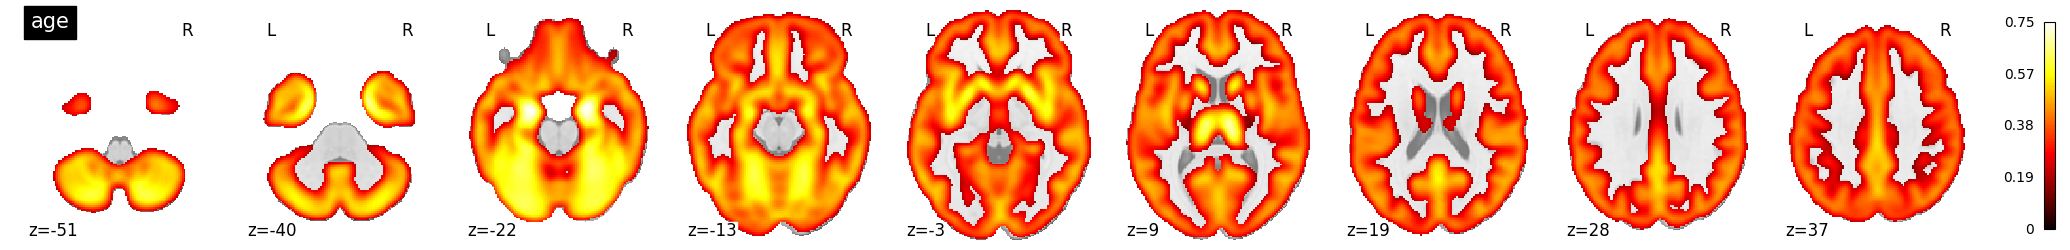

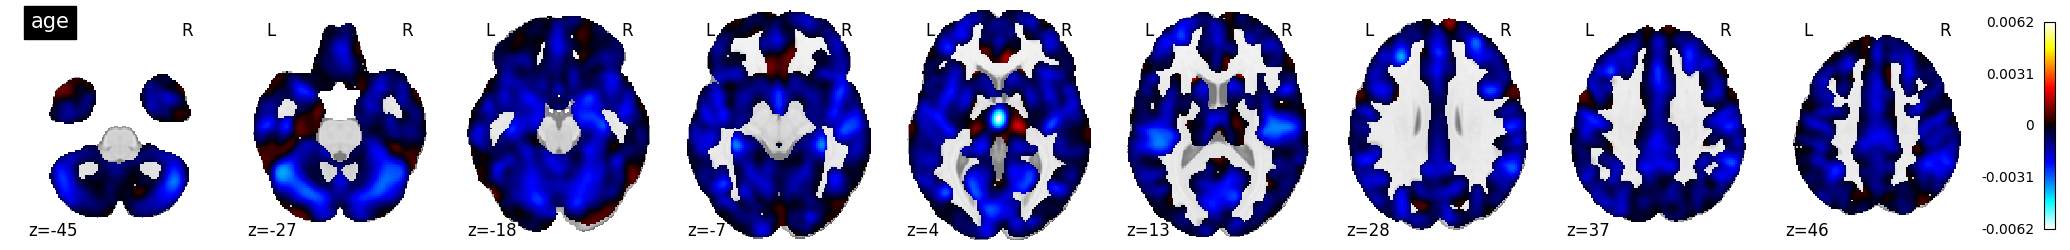

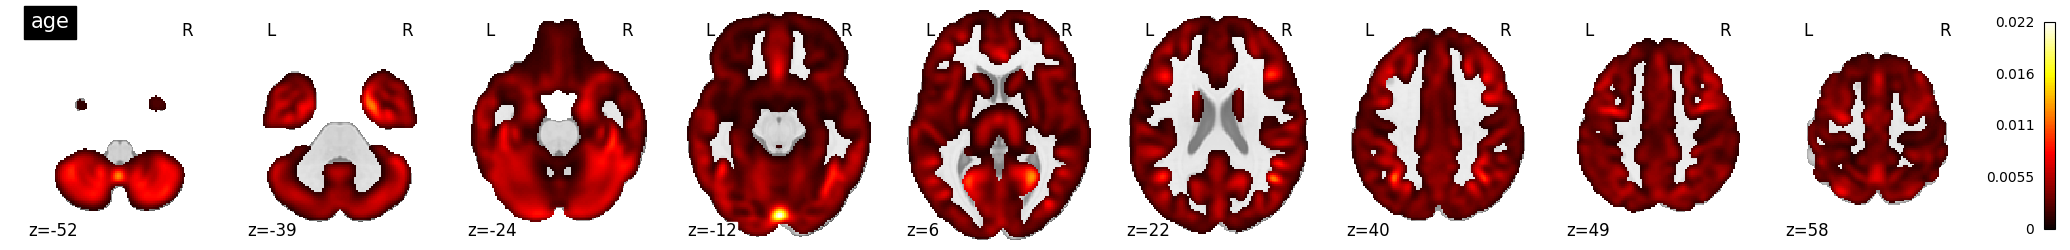

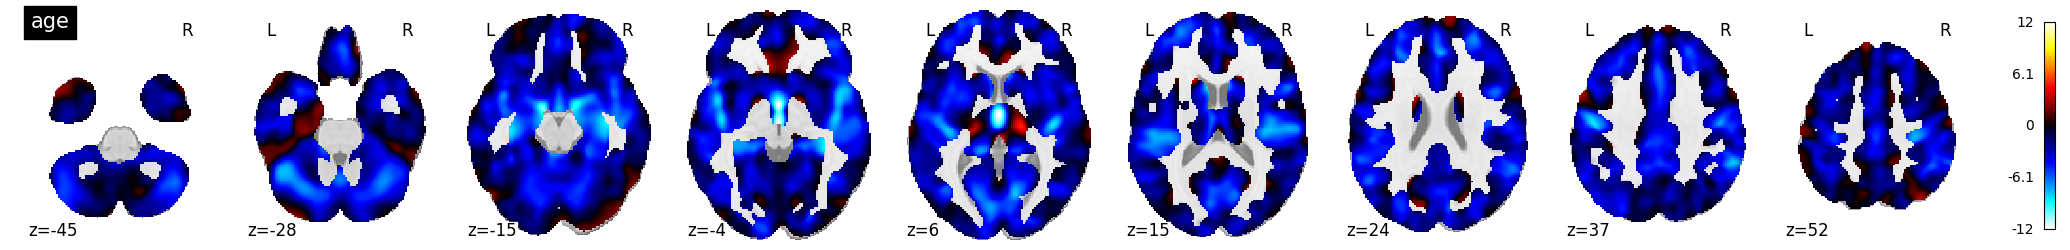

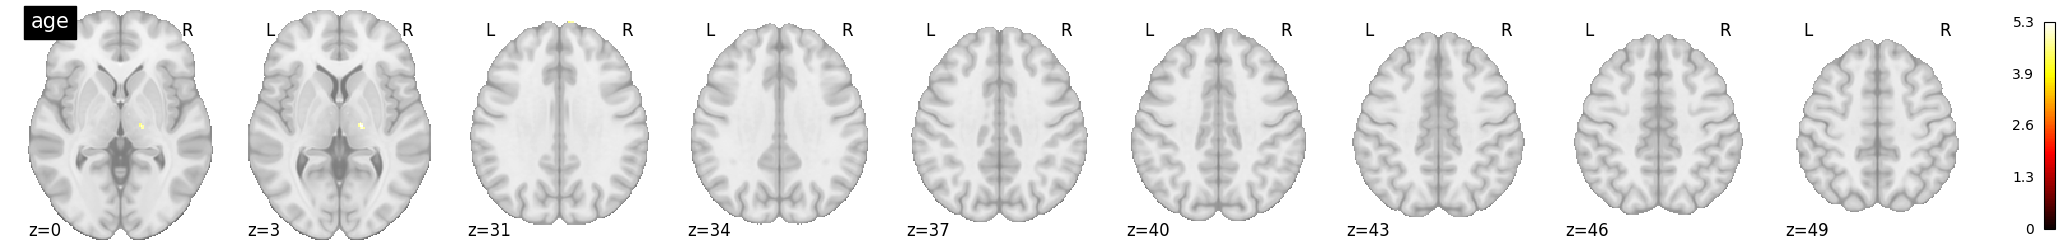

In [4]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
plotting.plot_stat_map('tmp/agecorrection/model/beta_0001.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/model/beta_0002.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/model/ResMS.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/contrast/spmT_0001.nii', display_mode='z', cut_coords=9, title='age')
plt.show()
plotting.plot_stat_map('tmp/agecorrection/thres/spmT_0001_thr.nii', display_mode='z', cut_coords=9, title='age')
plt.show()

In [5]:
data = getPandas('pat_data')
data_config = getConfig('data')
train_inds = data_config['indices']['pat']['train']
test_inds = data_config['indices']['pat']['test']
data_train = data.iloc[train_inds].reset_index(drop=True)
data_test = data.iloc[test_inds].reset_index(drop=True)
data_full = data.iloc[train_inds + test_inds].reset_index(drop=True)

In [6]:
from nilearn import image, plotting
# apply beta_0002.nii * voxel + beta0001.nii to all images
beta = image.load_img('tmp/agecorrection/model/beta_0002.nii').get_fdata()
intercept = image.load_img('tmp/agecorrection/model/beta_0001.nii')
uncorrected = data
for idx, rec in uncorrected.iterrows():
    img = os.path.abspath(rec['CAT12_SGM'])
    key = rec['KEY']
    age = rec['AGE']
    img = image.load_img(img)
    beta_age = beta * age
    beta_age = image.new_img_like(img, beta_age)
    img = image.math_img('img1 - beta', img1=img, beta=beta_age)
    #plotting.plot_stat_map(img, display_mode='z', cut_coords=9, title='corrected '+key)
    root = rec['IMG_ROOT']
    # save age corrected image to root
    img.to_filename(os.path.join(root, 'agecorrected.nii'))

In [7]:
train_good = data_train[data_train['CAT_MDS']==1]
train_bad = data_train[data_train['CAT_MDS']==0]
#train_good = data_full[data_full['CAT']==1]
#train_bad = data_full[data_full['CAT']==0]
img_good = train_good['IMG_ROOT'] + '/agecorrected.nii'
img_bad = train_bad['IMG_ROOT'] + '/agecorrected.nii'
img_good = img_good.apply(os.path.abspath)
img_bad = img_bad.apply(os.path.abspath)

In [17]:
train_good['AGE_CORRECTED_SGM'] = train_good['AGE_CORRECTED_SGM'].apply(os.path.abspath)
train_bad['AGE_CORRECTED_SGM'] = train_bad['AGE_CORRECTED_SGM'].apply(os.path.abspath)
train_good['CAT12_SGM'] = train_good['CAT12_SGM'].apply(os.path.abspath)
train_bad['CAT12_SGM'] = train_bad['CAT12_SGM'].apply(os.path.abspath)
writePandas('train_good', train_good)
writePandas('train_bad', train_bad)

/tmp/ipykernel_4159182/1620597751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_good['AGE_CORRECTED_SGM'] = train_good['AGE_CORRECTED_SGM'].apply(os.path.abspath)
/tmp/ipykernel_4159182/1620597751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_bad['AGE_CORRECTED_SGM'] = train_bad['AGE_CORRECTED_SGM'].apply(os.path.abspath)
/tmp/ipykernel_4159182/1620597751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [8]:
age_good = train_good['AGE']
age_bad = train_bad['AGE']
sex_good = train_good['SEX']
sex_bad = train_bad['SEX']
agelist = age_good.tolist() + age_bad.tolist()
sexlist = sex_good.tolist() + sex_bad.tolist()

In [9]:
wf = Workflow(name='voxelwise', base_dir='tmp')

# Age correction


ttest = Node(TwoSampleTTestDesign(), name='ttest')
ttest.inputs.group1_files = img_good.tolist()
ttest.inputs.group2_files = img_bad.tolist()
ttest.inputs.covariates = [
    {'name': 'age', 'vector': agelist},
    {'name': 'sex', 'vector': sexlist},
]

model = Node(EstimateModel(), name='model')
model.inputs.estimation_method = {'Classical': 1}

contrast = Node(EstimateContrast(), name='contrast')
con1 = ('good>bad','T', ['Group_{1}','Group_{2}'],[1,-1])
con2 = ('bad>good','T', ['Group_{1}','Group_{2}'],[-1,1])
con_list = [con1, con2]
contrast.inputs.contrasts = con_list
contrast.inputs.group_contrast = True

threshold = MapNode(Threshold(
    contrast_index=1,
    use_topo_fdr=True,
    use_fwe_correction=False,
    extent_threshold=0,
    height_threshold=0.05,
    height_threshold_type='p-value',
    extent_fdr_p_threshold=0.05), name='thres', iterfield=['stat_image'])

wf.connect([
    (ttest, model, [('spm_mat_file', 'spm_mat_file')]),
    (model, contrast, [('spm_mat_file', 'spm_mat_file'), ('beta_images', 'beta_images'), ('residual_image', 'residual_image')]),
    (contrast, threshold, [('spm_mat_file', 'spm_mat_file'), ('spmT_images', 'stat_image')])
])

wf.run()

230510-13:57:21,891 nipype.workflow INFO:
	 Workflow voxelwise settings: ['check', 'execution', 'logging', 'monitoring']
230510-13:57:21,911 nipype.workflow INFO:
	 Running serially.
230510-13:57:21,912 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.ttest" in "/home/biobot/disk/ldopa/tmp/voxelwise/ttest".
230510-13:57:21,918 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.ttest".
230510-13:57:21,926 nipype.workflow INFO:
	 [Node] Executing "ttest" <nipype.interfaces.spm.model.TwoSampleTTestDesign>
230510-13:57:32,526 nipype.workflow INFO:
	 [Node] Finished "ttest", elapsed time 10.599019s.
230510-13:57:32,544 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.model" in "/home/biobot/disk/ldopa/tmp/voxelwise/model".
230510-13:57:32,545 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.model".
230510-13:57:32,550 nipype.workflow INFO:
	 [Node] Executing "model" <nipype.interfaces.spm.model.EstimateModel>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:57:56,509 nipype.workflow INFO:
	 [Node] Finished "model", elapsed time 23.957224s.
230510-13:57:56,512 nipype.workflow INFO:
	 [Node] Setting-up "voxelwise.contrast" in "/home/biobot/disk/ldopa/tmp/voxelwise/contrast".
230510-13:57:56,514 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.contrast".
230510-13:57:56,519 nipype.workflow INFO:
	 [Node] Executing "contrast" <nipype.interfaces.spm.model.EstimateContrast>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:58:07,349 nipype.workflow INFO:
	 [Node] Finished "contrast", elapsed time 10.828988s.
230510-13:58:07,354 nipype.workflow INFO:
	 [Node] Outdated cache found for "voxelwise.thres".
230510-13:58:07,357 nipype.workflow INFO:
	 [Node] Setting-up "_thres0" in "/home/biobot/disk/ldopa/tmp/voxelwise/thres/mapflow/_thres0".
230510-13:58:07,358 nipype.workflow INFO:
	 [Node] Outdated cache found for "_thres0".
230510-13:58:07,362 nipype.workflow INFO:
	 [Node] Executing "_thres0" <nipype.interfaces.spm.model.Threshold>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:58:14,97 nipype.workflow INFO:
	 [Node] Finished "_thres0", elapsed time 6.733097s.
230510-13:58:14,100 nipype.workflow INFO:
	 [Node] Setting-up "_thres1" in "/home/biobot/disk/ldopa/tmp/voxelwise/thres/mapflow/_thres1".
230510-13:58:14,101 nipype.workflow INFO:
	 [Node] Outdated cache found for "_thres1".
230510-13:58:14,106 nipype.workflow INFO:
	 [Node] Executing "_thres1" <nipype.interfaces.spm.model.Threshold>


stty: 标准输入: 对设备不适当的 ioctl 操作


230510-13:58:20,845 nipype.workflow INFO:
	 [Node] Finished "_thres1", elapsed time 6.737735s.


stty: 标准输入: 对设备不适当的 ioctl 操作


/home/biobot/.pyenv/versions/3.10.9/lib/python3.10/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


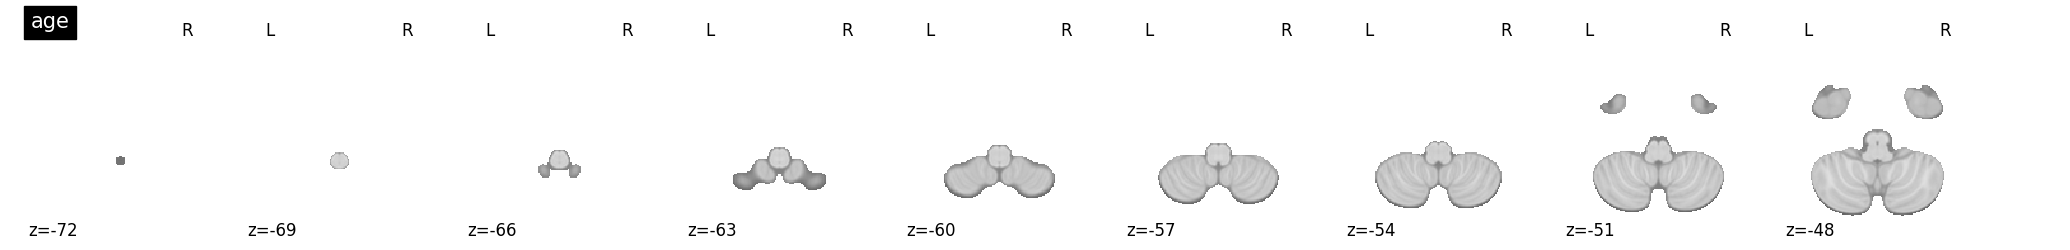

In [2]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
plotting.plot_stat_map('tmp/voxelwise/thres/mapflow/_thres0/spmT_0001_thr.nii', display_mode='z', cut_coords=9, title='age')
plt.show()

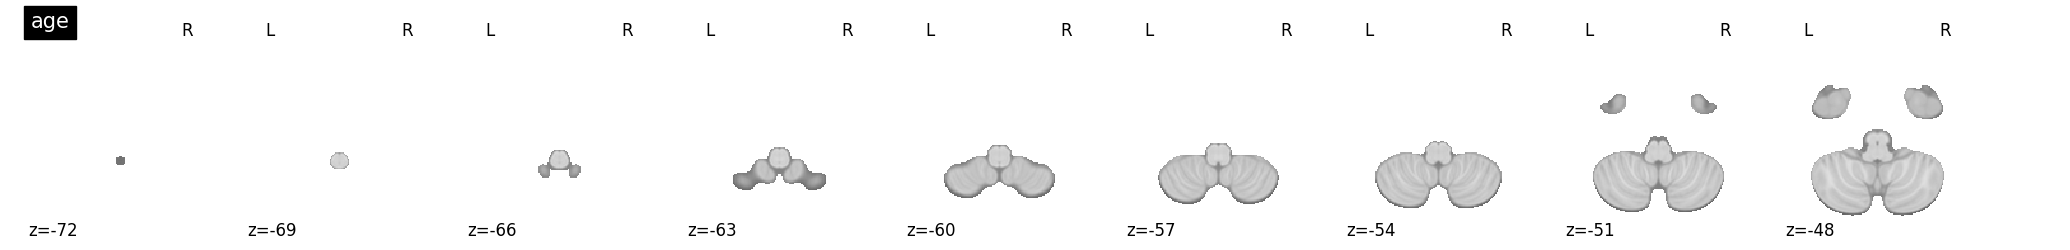

In [3]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
plotting.plot_stat_map('tmp/voxelwise/thres/mapflow/_thres1/spmT_0002_thr.nii', display_mode='z', cut_coords=9, title='age')
plt.show()

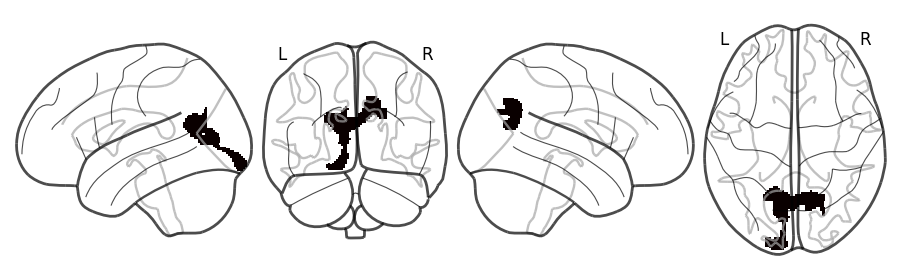

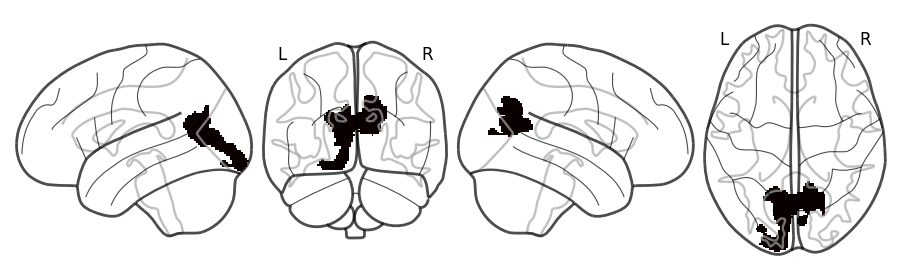

In [4]:
from nilearn import plotting, image
import matplotlib.pyplot as plt
plotting.plot_glass_brain('data/bin/agecorrection/corrected_mask.nii', display_mode='lyrz')
plotting.plot_glass_brain('data/bin/agecorrection/uncorrected_mask.nii', display_mode='lyrz')
plt.show()

In [25]:
data = getPandas('pat_data')
data_config = getConfig('data')
data = data.iloc[:2]
data['AGE_CORRECTED_SGM'] = data['AGE_CORRECTED_SGM'].apply(os.path.abspath)
imgs = data['AGE_CORRECTED_SGM'].tolist()
imgs = [image.load_img(img).get_fdata() for img in imgs]
imgs = np.stack(imgs, axis=0)
mask = image.load_img('data/bin/agecorrection/corrected_mask.nii').get_fdata()
imgs = imgs[:, mask>0]
imgs = imgs.reshape((imgs.shape[0], -1))

(2, 2481)
